In [1]:

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import pandas as pd

from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import invwishart
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import adjusted_rand_score

import seaborn as sns
from sklearn.metrics import mean_squared_error

import random

from models.PriorParameters import GMMPriorParameters
from models.PriorParameters import BMMPriorParameters
from models.GMMGibbs import GMMGibbs
from models.BMMGibbs import BMMGibbs
from models.GMMVBEM import GMMVBEM
from models.BMMVBEM import BMMVBEM
from models.BMMEM import BMMEM
from models.GMMEM import GMMEM

from utils.EvaluationUtilities import multi_restart, rmse

In [13]:
X_train = np.load("./../Datasets/Gaussian/Processed/synthetic/X_train_synthetic.npy")
y_train = np.load("./../Datasets/Gaussian/Processed/synthetic/y_train_synthetic.npy")

In [2]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [3]:
%%time
params = GMMPriorParameters(X_train, 5)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_train, num_iters=1000, burn=250)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.5670291662866412, 'avg_ll': np.float64(-2.4000511261272055), 'avg_pl': np.float64(-342.83292029484187)}
CPU times: user 18.4 s, sys: 27.4 ms, total: 18.4 s
Wall time: 18.5 s


In [4]:
best_sample = gmm_model.get_aligned_param_means()

In [6]:
print(best_sample['z'])

0


In [3]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [4]:
%%time
params = GMMPriorParameters(X_cover1, 3)
gmm_model = GMMGibbs(params)
samples = gmm_model.fit(X_cover1, num_iters=1000, burn=500)
obj = gmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.5639559276874555, 'avg_ll': np.float64(-2.9856906966963566), 'avg_pl': np.float64(-383.96041358691076)}
CPU times: user 37.7 s, sys: 19.4 ms, total: 37.8 s
Wall time: 37.9 s


In [19]:
X_fitted = gmm_model.posterior_predictive(X_cover1, gmm_model.get_map_params())
print(X_train[0])
print(X_cover1[0])
print(X_fitted[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[-1.7215677        nan -1.3470355        nan]
[-1.7215677 -2.0070899 -1.3470355 -1.37905  ]


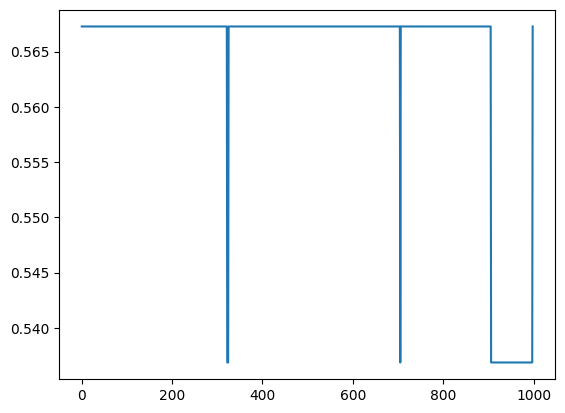

In [11]:
scores = [adjusted_rand_score(s['z'],y_train) for s in samples]
plt.plot(scores)

---

In [6]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

In [7]:
%%time
params = BMMPriorParameters(X_train, 2)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X_train, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y_train)
print(obj)

{'avg_ari': 0.6227286656280246, 'avg_ll': np.float64(-46.8256401308499), 'avg_pl': np.float64(-202374.20181412736)}
CPU times: user 7min 11s, sys: 214 ms, total: 7min 11s
Wall time: 1min 27s


---

In [3]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

In [4]:
%%time
params = BMMPriorParameters(X, 13)
bmm_model = BMMGibbs(params)
samples = bmm_model.fit(X, num_iters=1000, burn=250)
obj = bmm_model.get_summarizing_results(y)
print(obj)

{'avg_ari': 0.925169743040436, 'avg_ll': np.float64(-5.781961006432058), 'avg_pl': np.float64(-3626.33537077473)}
CPU times: user 3min 16s, sys: 4.08 s, total: 3min 20s
Wall time: 36.2 s


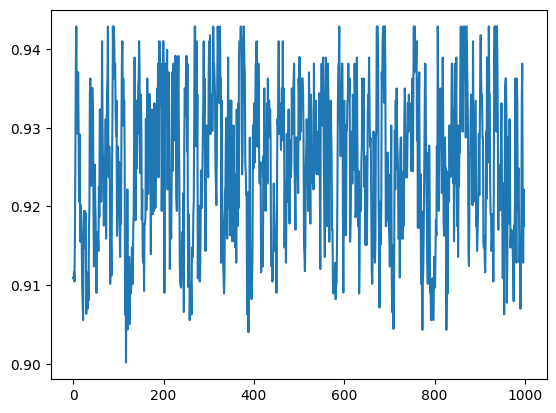

In [5]:
scores = [adjusted_rand_score(sample['z'],y) for sample in samples]
plt.plot(scores)

---
---

# VBEM

In [4]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [5]:
params = GMMPriorParameters(X_train, 3)
gmm_vbem_model = GMMVBEM(params)
result = multi_restart(gmm_vbem_model, X_train,y_train,10)

In [3]:
params = GMMPriorParameters(X_train, 3)
gmm_vbem_model = GMMVBEM(params)
result = gmm_vbem_model.fit(X_train, tol=1e-3)
adjusted_rand_score(y_train,result['z'])

0.5020708856589507

In [ ]:
params = GMMPriorParameters(X_cover1, 3)
gmm_vbem_model = GMMVBEM(params) 
result = gmm_vbem_model.fit(X_cover1, tol=1e-3)
adjusted_rand_score(y_train,result['z'])

0.5952220735662395

In [8]:
X_filled = gmm_vbem_model.posterior_predict(X_cover1)
print(X_train[0])
print(X_cover1[0])
print(X_filled[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[-1.7215677        nan        nan -1.3201685]
[-1.7215677   0.13849312 -1.3250586  -1.3201685 ]


In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

0.9505736893313538
CPU times: user 1min 24s, sys: 1.36 s, total: 1min 26s
Wall time: 17.8 s


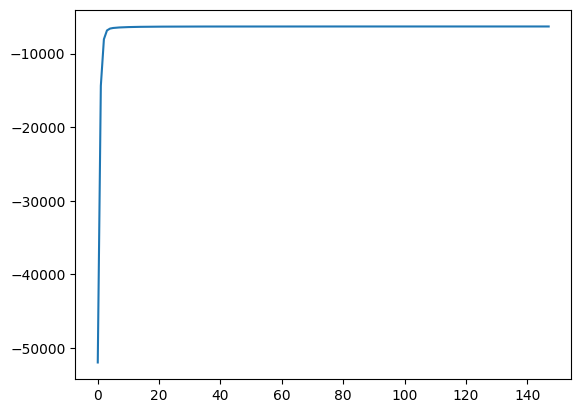

In [3]:
%%time
params = BMMPriorParameters(X, 13)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X, tol=1e-3)
print(adjusted_rand_score(y,result['z']))
plt.plot(result['elbos'])

In [9]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

0.1746315027206183
CPU times: user 3.19 s, sys: 1.7 ms, total: 3.19 s
Wall time: 582 ms


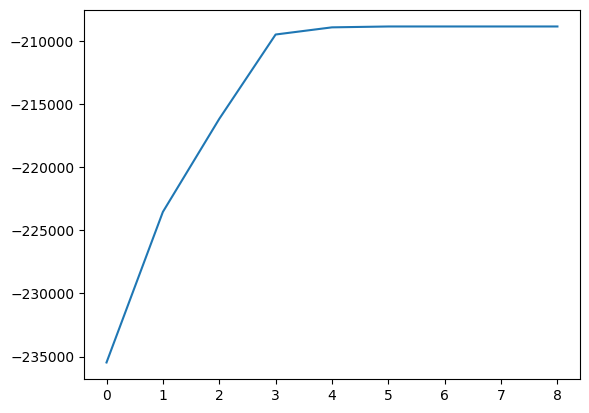

In [10]:
%%time
params = BMMPriorParameters(X_train, 2)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X_train, tol=1e-3)
print(adjusted_rand_score(y_train,result['z']))
plt.plot(result['elbos'])

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

0.37635089598621113
CPU times: user 7min 48s, sys: 14.9 s, total: 8min 3s
Wall time: 3min 14s


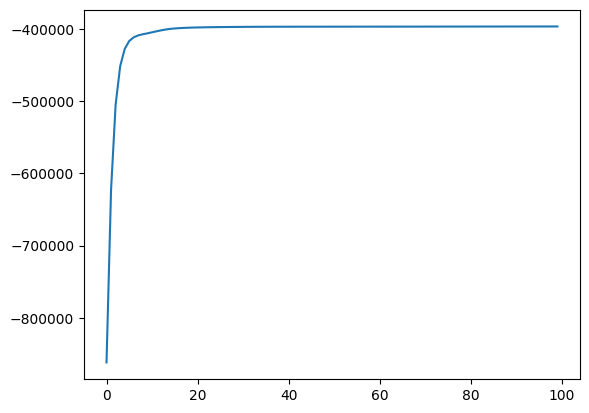

In [4]:
%%time
params = BMMPriorParameters(X_mnist_cover1, 10)
bmm_vbem_model = BMMVBEM(params)
result = bmm_vbem_model.fit(X_mnist_cover1, tol=1e-3)
print(adjusted_rand_score(Y_mnist_train,result['z']))
plt.plot(result['elbos'])

In [7]:
def paint_mnist(X):
    figure = plt.figure(figsize=(7, 3.5))
    rows, cols= 2, 5
    for k in range(10):
        img = X[k, :].reshape(28, 28)
        figure.add_subplot(rows, cols, k+1)
        plt.title(k)
        plt.axis("off")
        plt.imshow(img, cmap="gray")
    plt.show()

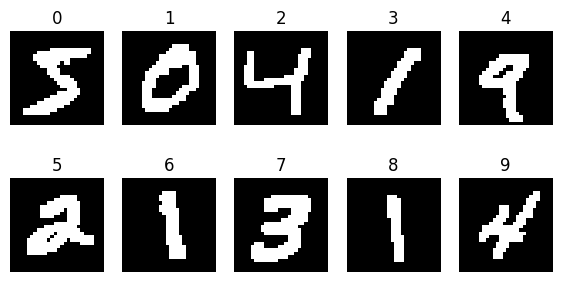

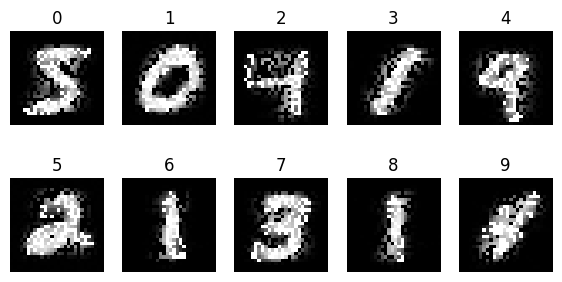

In [8]:
X_filled = bmm_vbem_model.posterior_predict(X_mnist_cover1)
paint_mnist(X_mnist_train)
paint_mnist(X_filled)

---

In [2]:
dirpath = "./../Datasets/Bernoulli/Processed/mushroom/"

X_train = np.load(dirpath + "X_train_mushroom.npy")
y_train = np.load(dirpath + "y_train_mushroom.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [4]:
em_bmm_model = BMMEM(2)
z, pi, theta, ll = em_bmm_model.fit(X_cover1)
print(adjusted_rand_score(z, y_train))

0.5958466451771957


In [2]:
dirpath = "./../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [3]:
em_gmm_model = GMMEM(3)
result = em_gmm_model.fit(X_cover1)
print(adjusted_rand_score(result['z'], y_train))

0.5035022251126979


In [7]:
X_filled = em_gmm_model.posterior_predict_impute(X_cover1)
print(X_train[0])
print(X_cover1[0])
print(X_filled[0])

[-1.72156775 -0.32483982 -1.34703555 -1.32016847]
[       nan -0.3248398        nan -1.3201685]
[-1.4667654 -0.3248398 -1.3426257 -1.3201685]


In [ ]:
em_gmm_model = GMMEM(3)
result = em_gmm_model.fit(X_train)
print(adjusted_rand_score(result['z'], y_train))

0.09535551258584408
